In [1]:
from ohsome import OhsomeClient

import altair as alt
import altair_tiles as til
import geopandas as gpd
import pandas as pd

import json
import osm2geojson
import requests

import datetime

In [2]:
#This Script gets a geometry from osm via overpass and gets a osm streetnetwork incl history for this geometry.
# then a virtual street network for each year (1st of Jan) is created to vizualize via altair.

# get geometry

In [3]:
## Should use [out:json] in the query as later osmtogeojson does not parse XML
#query = """
#[out:json][timeout:25];
#area[name="Brandenburg"]->.searchArea;
#(relation["admin_level"="8"]["name"="Wildau"](area.searchArea););
#out body;
#>;
#out skel qt;
#"""
#
#url = "http://overpass-api.de/api/interpreter"
#r = requests.get(url, params={'data': query})#,  proxies=proxies)
#
#res_geojson = osm2geojson.json2geojson(r.json())

In [4]:
#gdf_osm_shape = gpd.GeoDataFrame.from_features(res_geojson, crs="4326")
#gdf_osm_shape

In [5]:
# got bbox from: https://geojson.io/#new&map=15.24/52.466861/13.432173
gdf_osm_shape = gpd.read_file("bbox_hermannstr.geojson")

In [6]:
gdf_osm_shape

,geometry
0,"POLYGON ((13.42745 52.47043, 13.42745 52.46329..."


<Axes: >

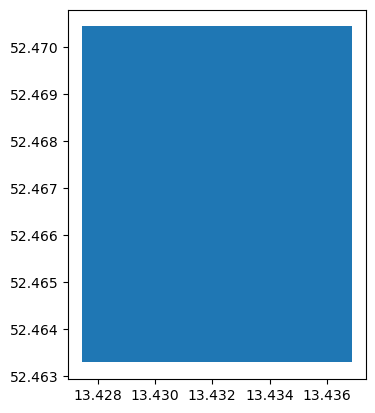

In [7]:
gdf_osm_shape_poly=gdf_osm_shape#[gdf_osm_shape["type"]=="relation"]
gdf_osm_shape_poly.plot()

# get network incl. history

In [8]:
client = OhsomeClient()

In [9]:
time = "2008-01-01,2024-01-01"
fltr = "highway=* and type:way"
properties = "tags" # to retreive OSM tags along with the geometries
bpolys=gdf_osm_shape_poly

In [10]:
response = client.elementsFullHistory.geometry.post(bpolys=bpolys, time=time, filter=fltr, properties=properties, timeout=100)

In [11]:
response_df = response.as_dataframe()
response_df

geometry  \
@osmId         @validFrom          @validTo                                                                 
way/1000841841 2021-11-09 15:51:19 2021-11-27 22:15:25  LINESTRING (13.42984 52.47043, 13.42969 52.47041)   
               2021-11-27 22:15:25 2021-12-08 15:34:08  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2021-12-08 15:34:08 2022-01-01 16:29:05  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2022-01-01 16:29:05 2022-01-01 17:15:01  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2022-01-01 17:15:01 2022-10-17 19:21:53  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
...                                                                                                   ...   
way/999212810  2023-05-27 10:22:45 2023-07-01 15:38:43  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-07-01 15:38:43 2023-11-01 13:20:13  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-01 13:20:13 2023-11-03 06:41:54  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-03 06:41:54 2023-11-11 11:35:28  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-11 11:35:28 2024-01-01 00:00:00  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   

                                                                                              @other_tags  
@osmId         @validFrom          @validTo                                                                
way/1000841841 2021-11-09 15:51:19 2021-11-27 22:15:25      {'highway': 'service', 'service': 'driveway'}  
               2021-11-27 22:15:25 2021-12-08 15:34:08      {'highway': 'service', 'service': 'driveway'}  
               2021-12-08 15:34:08 2022-01-01 16:29:05      {'highway': 'service', 'service': 'driveway'}  
               2022-01-01 16:29:05 2022-01-01 17:15:01      {'highway': 'service', 'service': 'driveway'}  
               2022-01-01 17:15:01 2022-10-17 19:21:53      {'highway': 'service', 'service': 'driveway'}  
...                                                                                                   ...  
way/999212810  2023-05-27 10:22:45 2023-07-01 15:38:43  {'cycleway:right': 'lane', 'cycleway:right:buf...  
               2023-07-01 15:38:43 2023-11-01 13:20:13  {'cycleway:right': 'lane', 'cycleway:right:buf...  
               2023-11-01 13:20:13 2023-11-03 06:41:54  {'cycleway:right': 'lane', 'cycleway:right:buf...  
               2023-11-03 06:41:54 2023-11-11 11:35:28  {'cycleway:right': 'lane', 'cycleway:right:buf...  
               2023-11-11 11:35:28 2024-01-01 00:00:00  {'cycleway:right': 'lane', 'cycleway:right:buf...  

[6382 rows x 2 columns]

### adding tags to df

In [12]:
def addingExtraTags(df_):
    df=df_.copy()
    for ind,row in df.iterrows():        
        tags = row['@other_tags']
        # Print the keys and values
        for key, value in tags.items():
            if key=="maxspeed":
                df.at[ind, "maxspeed"] = value

    return df

In [13]:
selected_ms=addingExtraTags(response_df)
selected_ms

geometry  \
@osmId         @validFrom          @validTo                                                                 
way/1000841841 2021-11-09 15:51:19 2021-11-27 22:15:25  LINESTRING (13.42984 52.47043, 13.42969 52.47041)   
               2021-11-27 22:15:25 2021-12-08 15:34:08  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2021-12-08 15:34:08 2022-01-01 16:29:05  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2022-01-01 16:29:05 2022-01-01 17:15:01  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2022-01-01 17:15:01 2022-10-17 19:21:53  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
...                                                                                                   ...   
way/999212810  2023-05-27 10:22:45 2023-07-01 15:38:43  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-07-01 15:38:43 2023-11-01 13:20:13  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-01 13:20:13 2023-11-03 06:41:54  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-03 06:41:54 2023-11-11 11:35:28  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-11 11:35:28 2024-01-01 00:00:00  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   

                                                                                              @other_tags  \
@osmId         @validFrom          @validTo                                                                 
way/1000841841 2021-11-09 15:51:19 2021-11-27 22:15:25      {'highway': 'service', 'service': 'driveway'}   
               2021-11-27 22:15:25 2021-12-08 15:34:08      {'highway': 'service', 'service': 'driveway'}   
               2021-12-08 15:34:08 2022-01-01 16:29:05      {'highway': 'service', 'service': 'driveway'}   
               2022-01-01 16:29:05 2022-01-01 17:15:01      {'highway': 'service', 'service': 'driveway'}   
               2022-01-01 17:15:01 2022-10-17 19:21:53      {'highway': 'service', 'service': 'driveway'}   
...                                                                                                   ...   
way/999212810  2023-05-27 10:22:45 2023-07-01 15:38:43  {'cycleway:right': 'lane', 'cycleway:right:buf...   
               2023-07-01 15:38:43 2023-11-01 13:20:13  {'cycleway:right': 'lane', 'cycleway:right:buf...   
               2023-11-01 13:20:13 2023-11-03 06:41:54  {'cycleway:right': 'lane', 'cycleway:right:buf...   
               2023-11-03 06:41:54 2023-11-11 11:35:28  {'cycleway:right': 'lane', 'cycleway:right:buf...   
               2023-11-11 11:35:28 2024-01-01 00:00:00  {'cycleway:right': 'lane', 'cycleway:right:buf...   

                                                       maxspeed  
@osmId         @validFrom          @validTo                      
way/1000841841 2021-11-09 15:51:19 2021-11-27 22:15:25      NaN  
               2021-11-27 22:15:25 2021-12-08 15:34:08      NaN  
               2021-12-08 15:34:08 2022-01-01 16:29:05      NaN  
               2022-01-01 16:29:05 2022-01-01 17:15:01      NaN  
               2022-01-01 17:15:01 2022-10-17 19:21:53      NaN  
...                                                         ...  
way/999212810  2023-05-27 10:22:45 2023-07-01 15:38:43       30  
               2023-07-01 15:38:43 2023-11-01 13:20:13       30  
               2023-11-01 13:20:13 2023-11-03 06:41:54       30  
               2023-11-03 06:41:54 2023-11-11 11:35:28       30  
               2023-11-11 11:35:28 2024-01-01 00:00:00       30  

[6382 rows x 3 columns]

### adding year to linestrings, if current for 1st jan

In [14]:
#detect state on 1.1. of each year

selected_ms['year']=''

years=range(2010,2025,1)

for year in years:
    time_element = datetime.datetime.strptime(str(year)+"-01-01","%Y-%m-%d")
    for i,r in selected_ms.iterrows():
        validFrom=i[1]
        validTo=i[2]

        if (validFrom <= time_element) & (validTo >= time_element):
            if isinstance(r.year, list):
                r["year"].append(year)
                selected_ms.at[i, "year"] = r["year"]
            else:           
                selected_ms.at[i, "year"] = [year]


In [15]:
selected_ms_cop=selected_ms.copy()
selected_ms_cop

geometry  \
@osmId         @validFrom          @validTo                                                                 
way/1000841841 2021-11-09 15:51:19 2021-11-27 22:15:25  LINESTRING (13.42984 52.47043, 13.42969 52.47041)   
               2021-11-27 22:15:25 2021-12-08 15:34:08  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2021-12-08 15:34:08 2022-01-01 16:29:05  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2022-01-01 16:29:05 2022-01-01 17:15:01  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
               2022-01-01 17:15:01 2022-10-17 19:21:53  LINESTRING (13.42984 52.47043, 13.42980 52.470...   
...                                                                                                   ...   
way/999212810  2023-05-27 10:22:45 2023-07-01 15:38:43  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-07-01 15:38:43 2023-11-01 13:20:13  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-01 13:20:13 2023-11-03 06:41:54  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-03 06:41:54 2023-11-11 11:35:28  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   
               2023-11-11 11:35:28 2024-01-01 00:00:00  LINESTRING (13.43116 52.46790, 13.43103 52.46798)   

                                                                                              @other_tags  \
@osmId         @validFrom          @validTo                                                                 
way/1000841841 2021-11-09 15:51:19 2021-11-27 22:15:25      {'highway': 'service', 'service': 'driveway'}   
               2021-11-27 22:15:25 2021-12-08 15:34:08      {'highway': 'service', 'service': 'driveway'}   
               2021-12-08 15:34:08 2022-01-01 16:29:05      {'highway': 'service', 'service': 'driveway'}   
               2022-01-01 16:29:05 2022-01-01 17:15:01      {'highway': 'service', 'service': 'driveway'}   
               2022-01-01 17:15:01 2022-10-17 19:21:53      {'highway': 'service', 'service': 'driveway'}   
...                                                                                                   ...   
way/999212810  2023-05-27 10:22:45 2023-07-01 15:38:43  {'cycleway:right': 'lane', 'cycleway:right:buf...   
               2023-07-01 15:38:43 2023-11-01 13:20:13  {'cycleway:right': 'lane', 'cycleway:right:buf...   
               2023-11-01 13:20:13 2023-11-03 06:41:54  {'cycleway:right': 'lane', 'cycleway:right:buf...   
               2023-11-03 06:41:54 2023-11-11 11:35:28  {'cycleway:right': 'lane', 'cycleway:right:buf...   
               2023-11-11 11:35:28 2024-01-01 00:00:00  {'cycleway:right': 'lane', 'cycleway:right:buf...   

                                                       maxspeed    year  
@osmId         @validFrom          @validTo                              
way/1000841841 2021-11-09 15:51:19 2021-11-27 22:15:25      NaN          
               2021-11-27 22:15:25 2021-12-08 15:34:08      NaN          
               2021-12-08 15:34:08 2022-01-01 16:29:05      NaN  [2022]  
               2022-01-01 16:29:05 2022-01-01 17:15:01      NaN          
               2022-01-01 17:15:01 2022-10-17 19:21:53      NaN          
...                                                         ...     ...  
way/999212810  2023-05-27 10:22:45 2023-07-01 15:38:43       30          
               2023-07-01 15:38:43 2023-11-01 13:20:13       30          
               2023-11-01 13:20:13 2023-11-03 06:41:54       30          
               2023-11-03 06:41:54 2023-11-11 11:35:28       30          
               2023-11-11 11:35:28 2024-01-01 00:00:00       30  [2024]  

[6382 rows x 4 columns]

In [16]:
selected_ms_cop['year']=selected_ms_cop['year'].astype(str)
#selected_ms_cop.year.value_counts()

In [17]:
selected_ms_cop['year']=selected_ms_cop['year'].astype(str)

selected_ms_years = pd.DataFrame()

for year in years:
    selected_ms_year = selected_ms_cop[selected_ms_cop['year'].str.contains(str(year))].copy()
    selected_ms_year['year_unique']=year
    selected_ms_years=pd.concat([selected_ms_years,selected_ms_year])

In [18]:
selected_ms_=selected_ms_years.reset_index()
selected_ms_gdf = gpd.GeoDataFrame(
    selected_ms_, geometry="geometry", crs="EPSG:4326"
)

In [19]:
# get rid of other geometry types but linestring
selected_ms_gdf_fil = selected_ms_gdf[selected_ms_gdf.geometry.type=="LineString"]
selected_ms_gdf_fil.head()

,@osmId,@validFrom,@validTo,geometry,@other_tags,maxspeed,year,year_unique
0,way/18593434,2009-09-26 09:26:16,2011-09-25 17:46:11,"LINESTRING (13.43643 52.46694, 13.43631 52.46731)","{'cycleway': 'opposite', 'highway': 'residenti...",30,"[2010, 2011]",2010
1,way/18908136,2009-08-08 11:33:14,2010-12-26 18:12:39,"LINESTRING (13.43625 52.46753, 13.43631 52.46731)","{'highway': 'residential', 'lanes': '2', 'maxs...",30,[2010],2010
2,way/19800046,2009-08-12 12:22:30,2010-04-27 17:47:35,"LINESTRING (13.42745 52.46394, 13.43294 52.46459)","{'highway': 'secondary', 'maxspeed': '30', 'na...",30,[2010],2010
3,way/24159804,2009-08-08 11:33:14,2010-12-26 18:12:39,"LINESTRING (13.43591 52.46846, 13.43625 52.46753)","{'bridge': 'yes', 'highway': 'residential', 'l...",30,[2010],2010
4,way/25697595,2009-09-26 08:52:13,2010-08-18 17:48:32,"LINESTRING (13.42745 52.46590, 13.43197 52.46641)","{'highway': 'secondary', 'maxspeed': '30', 'na...",30,[2010],2010


In [20]:
#selected_ms_gdf_fil_years=selected_ms_gdf_fil[selected_ms_gdf_fil.year_unique>2016]
selected_ms_gdf_fil_years=selected_ms_gdf_fil
len(selected_ms_gdf_fil_years)

4084

In [21]:
source=selected_ms_gdf_fil_years[["geometry",'year_unique','maxspeed']]#[:4000]
source=source.dropna(subset=['maxspeed'])

In [22]:
len(source)

1161

In [23]:
#source.drop_duplicates(subset=['maxspeed','geometry','year_unique'])

In [24]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [25]:
#
#    slider = alt.binding_range(min=2010, max=2023, step=1, name='year_unique')
#    
#    selector = alt.selection_point(
#        name="SelectorName",
#        fields=['year_unique'],
#        bind=slider,
#        value=2020
#       # value=[{'yearU': [2020]}]
#    )
#    
#    geoshape = (
#        alt.Chart(source, width=600, height=600)
#        .mark_geoshape(fillOpacity=0, 
#                       #stroke="green",
#                       strokeWidth=2,
#                      )
#        .encode(stroke=alt.Stroke("maxspeed:N", legend={"symbolFillColor":'gray', "symbolStrokeWidth":7})
#               ).project(type="mercator")
#    ).add_params(
#        selector
#    ).transform_filter(
#       selector
#    )
#    
#    geoshape

In [26]:
#til_geo=til.add_tiles(geoshape, provider=til.providers.CartoDB.Positron)

In [27]:
# buffer to clean base-shape
gdf_osm_shape_poly_b=gdf_osm_shape_poly.buffer(0.0001)

C:\Users\simon\AppData\Local\Temp\ipykernel_19652\451598931.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_osm_shape_poly_b=gdf_osm_shape_poly.buffer(0.0001)


In [107]:
slider = alt.binding_range(min=2010, max=2024, step=1, name='Jahr auswählen:')

selector = alt.selection_point(
    name="SelectorName",
    fields=['year_unique'],
    bind=slider,
    value=2010
   # value=[{'yearU': [2020]}]
)
geoshape_base=alt.Chart(gdf_osm_shape_poly_b).mark_geoshape(opacity=0.08)


chart_title = alt.TitleParams(
    ["Änderungen der zul. Geschwindigkeit (OSM, maxspeed) im zeitlicher Verlauf","im Bereich der südlichen Hermannstraße"],
    subtitle=["", "© OpenStreetMap contributors powered by ohsome API","created by FG Radverkehr - TH Wildau"],
)

geoshape = (
    alt.Chart(source, width=600, height=600, title=chart_title)
    .mark_geoshape(fillOpacity=0, 
                   #stroke="green",
                   strokeWidth=2,
                  )
    .encode(
        stroke=alt.Stroke("maxspeed:Q", 
                         # legend={"symbolFillColor":'gray', "symbolStrokeWidth":7, "orient":"bottom-right", "direction": 'vertical',"legendX": 430}
                         #legend=alt.Legend(
                         #       orient='none',
                         #       legendX=560, legendY=370,
                         #       direction='vertical',
                         #       titleAnchor='middle')
                         ).scale(domain=[10, 80],scheme="redyellowgreen", reverse=True),
        tooltip=['maxspeed','year_unique']
           ).project(type="mercator")
).add_params(
    selector
).transform_filter(
   selector
)

chrt=geoshape_base + geoshape
chrt

alt.LayerChart(...)

In [108]:
til_geo=til.add_tiles(chrt, provider=til.providers.CartoDB.Positron)
#til_geo=til.add_tiles(chrt, provider=til.providers.Esri.WorldImagery)

In [109]:
til_geo

alt.LayerChart(...)

In [110]:
til_geo.save('historic_osm-maxspeed_hermannstr.html')